In [1]:
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from torchvision.datasets import ImageFolder
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import h5py

/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
/tmp/ipykernel_330379/339696910.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
!nvidia-smi | grep '/vol/bitbucket/ms922/myenv/bin/python' | awk '{ print $5 }' | xargs -n1 kill -9


Usage:
 kill [options] <pid> [...]

Options:
 <pid> [...]            send signal to every <pid> listed
 -<signal>, -s, --signal <signal>
                        specify the <signal> to be sent
 -q, --queue <value>    integer value to be sent with the signal
 -l, --list=[<signal>]  list all signal names, or convert one to a name
 -L, --table            list all signal names in a nice table

 -h, --help     display this help, and exit
 -V, --version  output version information, and exit

For more details, see kill(1).


In [3]:
!nvidia-smi

Failed to initialize NVML: Driver/library version mismatch
NVML library version: 535.183


In [4]:
from networks import *

In [5]:
# Hyperparameters
nz = 100  # Size of z latent vector (i.e., generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
nc = 1    # Number of channels in the training images

# Create the generator and discriminator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(ndf, nc).to(device)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [6]:
# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()


In [7]:
select_class = None

In [8]:
class HDF5Dataset(Dataset):
    def __init__(self, h5_file_path, dataset_name, transform=None):
        self.h5_file_path = h5_file_path
        self.dataset_name = dataset_name
        self.h5_file = h5py.File(h5_file_path, 'r')
        self.dataset = self.h5_file[dataset_name]
        self.length = self.dataset.shape[0]
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        data = self.dataset[idx, :]
        if data.ndim == 2:  # Ensure single-channel format
            data = np.expand_dims(data, axis=0)
        data = data.transpose((1, 2, 0))  # Change to HWC format for PIL
        if self.transform:
            data = self.transform(data)
        return data

    def __del__(self):
        self.h5_file.close()

In [10]:
batch_size = 32

# Data loading
mean = [0.5]
std = [0.5]

img_size = 64

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.Resize(img_size),  # Resize the image
    transforms.CenterCrop(img_size),  # Center crop the image
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the tensor
])

dataset_path = '../bkainz_data/combined_inp_filter_224x288.hdf5'
dataset_name = "images_train_filtered"
dataset = HDF5Dataset(dataset_path, dataset_name, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
def show(img):
    npimg = img.cpu().numpy()
    print(npimg.shape)
    if npimg.shape[0] == 1:  # Check if the image is single-channel
        npimg = npimg.squeeze(0)  # Remove the channel dimension
        plt.imshow(npimg, cmap='gray')  # Use grayscale colormap
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

mean_tensor = torch.Tensor(mean)
std_tensor = torch.Tensor(std)

unnormalize = transforms.Normalize((-mean_tensor / std_tensor).tolist(), (1.0 / std_tensor).tolist())

def denorm(x, channels=None, w=None ,h=None, resize = False):

    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

(1, 64, 64)


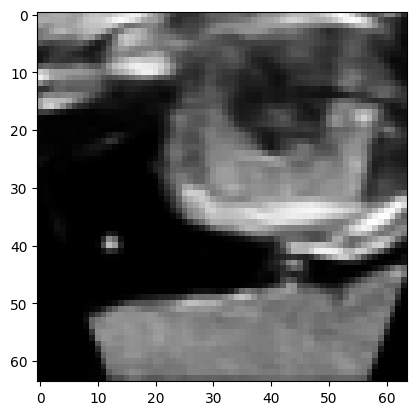

In [12]:
samples = next(iter(data_loader))
show(samples[0])

In [13]:
def show_grid(images):
    # Denormalize and create grid
    images = denorm(images)
    grid = make_grid(images, nrow=8, padding=2, normalize=False, value_range=None, scale_each=False, pad_value=0)
    npgrid = grid.cpu().numpy()
    
    # Handle single-channel and multi-channel images
    if npgrid.shape[0] == 1:  # Single-channel images
        npgrid = npgrid.squeeze(0)
        plt.imshow(npgrid, cmap='gray')
    else:  # Multi-channel images
        plt.imshow(np.transpose(npgrid, (1, 2, 0)))
    plt.show()

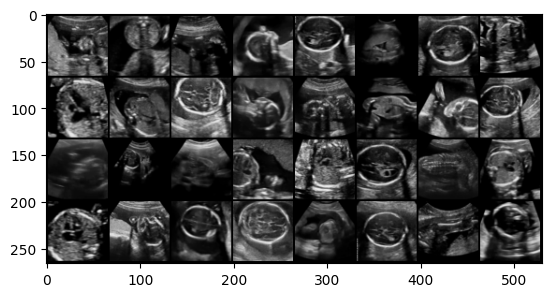

In [14]:
samples = next(iter(data_loader))
show_grid(samples)

torch.Size([32, 1, 64, 64])
(3, 266, 530)


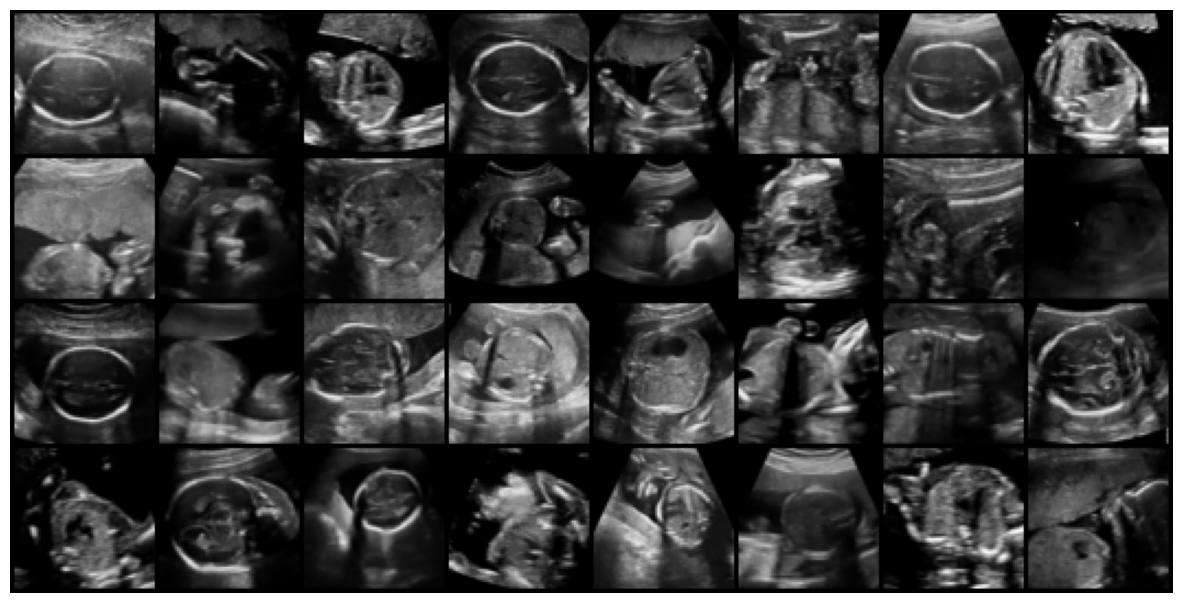

In [15]:
samples = next(iter(data_loader))

samples = samples.cpu()

print(samples.shape)

samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

In [16]:
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

In [17]:
# Training Loop
num_epochs = 50
real_label = 1
fake_label = 0

for epoch in range(num_epochs):
    tepoch = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, (data) in tepoch:
        netD.zero_grad()
        real_cpu = data.to(device)
        
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        tepoch.set_description(f"Epoch {epoch+1}/{num_epochs} Iter {batch_idx+1}/{len(data_loader)}")
        tepoch.set_postfix(Loss_D=errD.item(), Loss_G=errG.item(), D_x=D_x, D_G_z=f"{D_G_z1:.4f}/{D_G_z2:.4f}")

            # print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
            #         % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        

    with torch.no_grad():
        netG.eval()
        fake = netG(fixed_noise)

        save_img_path = f"./samples/fake_samples_epoch_{epoch:02d}.png"
        if select_class is not None:
            save_img_path = f"./samples/fake_samples_epoch_{epoch:02d}_{select_class}.png"
        save_image(denorm(fake.cpu()).float(), save_img_path)
        netG.train()
    
    
    save_model_path = f'./models/net_G_relu_64_video_net_new_epoch_{epoch:02d}.pth'
    if select_class is not None:
        save_model_path = f'./models/net_G_relu_64_video_net_new_epoch_{epoch:02d}_{select_class}.pth'
    torch.save(netG.state_dict(), save_model_path)

Epoch 1/50:   0%|          | 0/2518 [00:00<?, ?it/s]

Epoch 1/50 Iter 71/2518:   3%|▎         | 71/2518 [00:27<15:41,  2.60it/s, D_G_z=0.0000/0.0000, D_x=0.575, Loss_D=1.59, Loss_G=20.4]  
Exception ignored in: <function HDF5Dataset.__del__ at 0x7826a22f8310>
Traceback (most recent call last):
  File "/tmp/ipykernel_328626/245307583.py", line 25, in __del__
AttributeError: 'HDF5Dataset' object has no attribute 'h5_file'


KeyboardInterrupt: 